
--- Analyzing Model: Vgm, all atlases ---
  Samples for MDD vs HC: HC=501, MDD=301
  Samples for SCHZ vs HC: HC=501, SCHZ=845
  Samples for CTT-SCHZ vs HC: HC=501, CTT-SCHZ=47
  Samples for CTT-MDD vs HC: HC=501, CTT-MDD=27

--- Analyzing Model: Vgm/Vwm/Vcsf, all atlases ---
  Samples for MDD vs HC: HC=501, MDD=301
  Samples for SCHZ vs HC: HC=501, SCHZ=845
  Samples for CTT-SCHZ vs HC: HC=501, CTT-SCHZ=47
  Samples for CTT-MDD vs HC: HC=501, CTT-MDD=27

--- Analyzing Model: Vgm, neuromorphometrics/lpba40 ---
  Samples for MDD vs HC: HC=501, MDD=301
  Samples for SCHZ vs HC: HC=501, SCHZ=845
  Samples for CTT-SCHZ vs HC: HC=501, CTT-SCHZ=47
  Samples for CTT-MDD vs HC: HC=501, CTT-MDD=27

--- Analyzing Model: Vgm/Vwm/Vcsf, neuromorphometrics/lpba40 ---
  Samples for MDD vs HC: HC=501, MDD=301
  Samples for SCHZ vs HC: HC=501, SCHZ=845
  Samples for CTT-SCHZ vs HC: HC=501, CTT-SCHZ=47
  Samples for CTT-MDD vs HC: HC=501, CTT-MDD=27

ROC analysis saved as: /workspace/project/catatonia_V

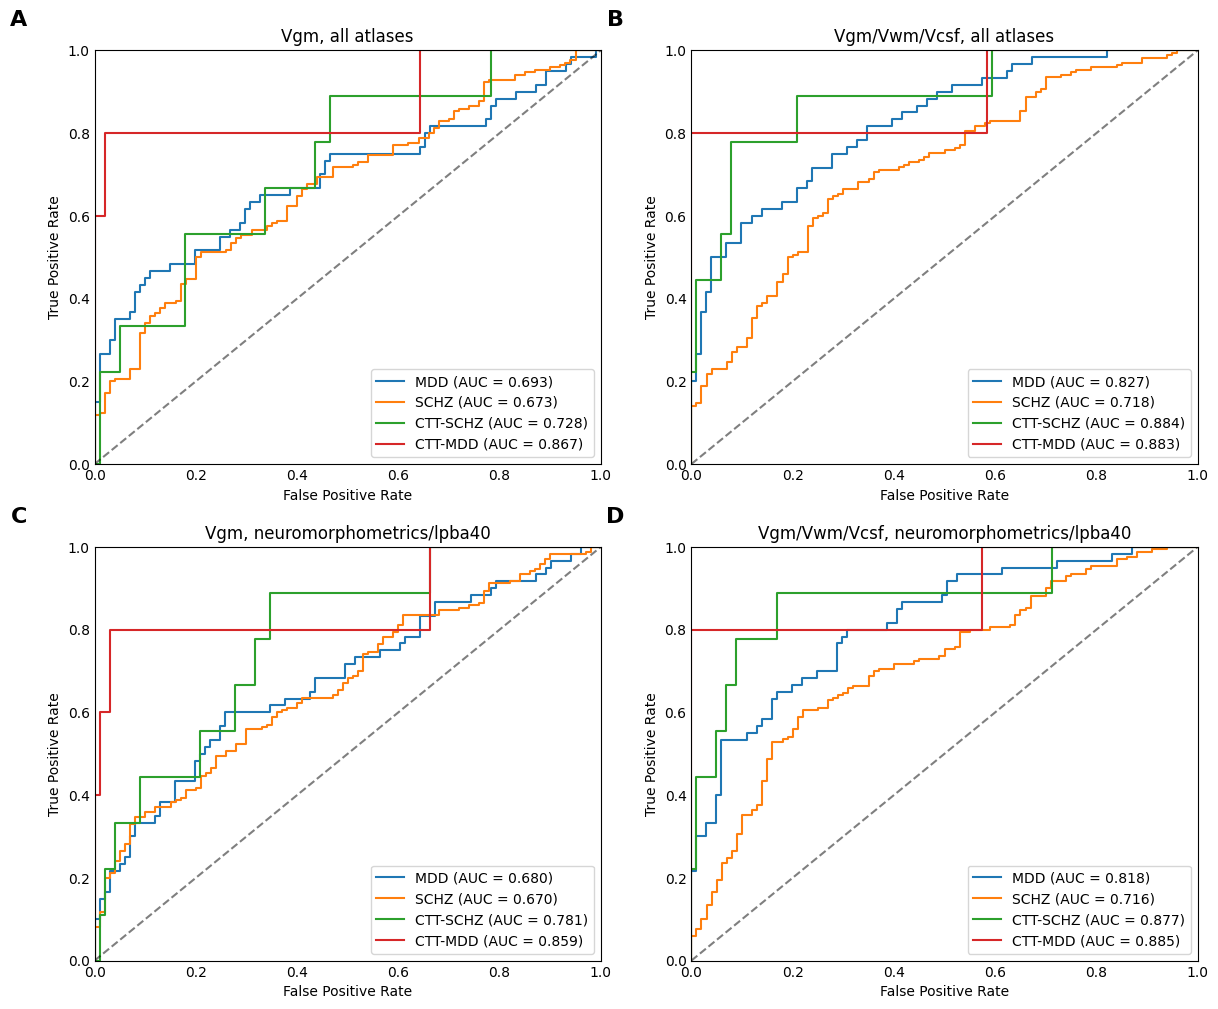

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, roc_auc_score
import re
import os
from PIL import Image
import string
import math

# Liste der CSV-Dateien mit entsprechenden Titeln
csv_paths = [
    "/workspace/project/catatonia_VAE-main_bq/analysis/TESTING/CTT(MDD_SCHZ)/deviation_results_norm_results_HC_V_g_m_all_20250601_2108_20250606_131920/deviation_scores_with_roi_names.csv", #Vgm, all
    "/workspace/project/catatonia_VAE-main_bq/analysis/TESTING/CTT(MDD_SCHZ)/deviation_results_norm_results_HC_Vgm_Vwm_Vcsf_all_20250530_1142_20250606_132210/deviation_scores_with_roi_names.csv", #all, all
    "/workspace/project/catatonia_VAE-main_bq/analysis/TESTING/CTT(MDD_SCHZ)/deviation_results_norm_results_HC_V_g_m_neuromorphometrics_cobra_lpba40_20250606_0349_20250618_132436/deviation_scores_with_roi_names.csv", #Vgm, neurom/lpba40
    "/workspace/project/catatonia_VAE-main_bq/analysis/TESTING/CTT(MDD_SCHZ)/deviation_results_norm_results_HC_Vgm_Vwm_Vcsf_neuromorphometrics_cobra_lpba40_20250606_0540_20250613_183712/deviation_scores_with_roi_names.csv" #all, neurom/lpba40
]

# Entsprechende Titel für die Plots
plot_titles = [
    "Vgm, all atlases",
    "Vgm/Vwm/Vcsf, all atlases",
    "Vgm, neuromorphometrics/lpba40",
    "Vgm/Vwm/Vcsf, neuromorphometrics/lpba40"
]

# Automatisches Grid-Layout berechnen
num_files = len(csv_paths)
cols = math.ceil(math.sqrt(num_files))  # Anzahl Spalten
rows = math.ceil(num_files / cols)      # Anzahl Zeilen

# Figsize dynamisch anpassen
fig_width = cols * 6  # 6 Einheiten pro Spalte
fig_height = rows * 5  # 5 Einheiten pro Zeile
fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height))

# Sicherstellen, dass axes immer ein 2D-Array ist
if rows == 1 and cols == 1:
    axes = np.array([[axes]])
elif rows == 1:
    axes = axes.reshape(1, -1)
elif cols == 1:
    axes = axes.reshape(-1, 1)

# Verarbeitung jeder Datei
for i, csv_path in enumerate(csv_paths):
    df = pd.read_csv(csv_path)

    # Titel aus der vordefinierten Liste verwenden
    plot_title = plot_titles[i]

    # Position im Grid bestimmen
    row = i // cols
    col = i % cols
    ax = axes[row, col]

    # Entferne Ticks, behalte nur Zahlen
    ax.tick_params(axis='both', which='both', length=0)

    # Subplot-Beschriftung außerhalb des Plots auf Höhe des Titels
    subplot_label = string.ascii_uppercase[i]
    ax.text(-0.15, 1.05, f'{subplot_label}', transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='bottom', ha='center')

    # Klassifikation: HC vs. andere Diagnosen
    df["Diagnosis"] = df["Diagnosis"].astype("category")
    diagnosis_list = df["Diagnosis"].unique()
    non_hc_classes = [d for d in diagnosis_list if d != "HC"]

    metadata_columns = ['Filename', 'Diagnosis', 'Age', 'Sex', 'Dataset',
                       'reconstruction_error', 'reconstruction_error_std',
                       'kl_divergence', 'kl_divergence_std']
    region_columns = [col for col in df.columns if col not in metadata_columns]

    # --- Start of added code for sample count output ---
    print(f"\n--- Analyzing Model: {plot_title} ---")
    # --- End of added code for sample count output ---

    # ROC-Kurven für jede Diagnose vs. HC
    roc_curves_plotted = False
    for diag in non_hc_classes:
        df_bin = df[df["Diagnosis"].isin(["HC", diag])].copy()
        df_bin["target"] = (df_bin["Diagnosis"] == diag).astype(int)

        X = df_bin[region_columns]
        y = df_bin["target"]

        if len(df_bin['target'].unique()) < 2 or len(df_bin) < 2:
            print(f"  Skipping {diag} vs HC for {plot_title}: Insufficient samples or only one class present.")
            continue

        # --- Start of added code for sample count output ---
        hc_count = df_bin[df_bin["Diagnosis"] == "HC"].shape[0]
        diag_count = df_bin[df_bin["Diagnosis"] == diag].shape[0]
        print(f"  Samples for {diag} vs HC: HC={hc_count}, {diag}={diag_count}")
        # --- End of added code for sample count output ---

        # Train-Test-Split mit stratifiziertem Sampling
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, stratify=y, test_size=0.2, random_state=42)
        except ValueError as e:
            print(f"  Skipping {diag} vs HC for {plot_title}: Stratification error - {e}")
            continue

        # Logistische Regression
        clf = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:, 1]

        # ROC-Kurve berechnen
        roc_auc = roc_auc_score(y_test, y_score)
        fpr, tpr, _ = roc_curve(y_test, y_score)

        # ROC-Kurve plotten
        ax.plot(fpr, tpr, label=f'{diag} (AUC = {roc_auc:.3f})')
        roc_curves_plotted = True

    # Diagonale Linie hinzufügen
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)

    # Achsenbeschriftungen und Titel
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"{plot_title}")

    # Legende nur hinzufügen, wenn ROC-Kurven geplottet wurden
    if roc_curves_plotted:
        ax.legend(loc="lower right")

    # Achsenlimits setzen
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

# Leere Subplots ausblenden (falls num_files < rows*cols)
for i in range(num_files, rows * cols):
    row = i // cols
    col = i % cols
    axes[row, col].axis('off')

plt.tight_layout(pad=0.5)

# Optional: Speichern des Plots
output_filename = "/workspace/project/catatonia_VAE-main_bq/src/z_figures_BA/roc_analysis_combined.png"
plt.savefig(output_filename, dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print(f"\nROC analysis saved as: {output_filename}")

plt.show()

In [13]:
import pandas as pd

# Lade die Daten
csv_path = "/workspace/project/catatonia_VAE-main_bq/analysis/TESTING/deviation_results_norm_results_HC_V_g_m_neuromorphometrics_20250605_1037_20250619_190608/deviation_scores_with_roi_names.csv"

df = pd.read_csv(csv_path)

# Wähle nur die Z-Scores der Hirnregionen
metadata_columns = ["Filename", "Diagnosis", "Age", "Sex", "Dataset","reconstruction_error","reconstruction_error_std","kl_divergence","kl_divergence_std", "deviation_score","deviation_score_zscore","deviation_score_zscore","deviation_score_percentile"]
                                          
region_columns = [col for col in df.columns if col not in metadata_columns]

# Berechne die Korrelationsmatrix
corr_matrix = df[region_columns].corr()

# Finde stark korrelierende Paare (Threshold anpassen)
threshold = 0.75  
strong_corrs = (
    corr_matrix.abs()
    .unstack()
    .sort_values(ascending=False)
    .drop_duplicates()
)

# Filtere die stärksten Korrelationen
strong_corrs = strong_corrs[strong_corrs >= threshold]

# Speichern der Ergebnisse in eine Datei
with open("/workspace/project/catatonia_VAE-main_bq/src/output.txt", "w") as f:
    f.write("Stark korrelierende Hirnregionen:\n\n")
    f.write(str(strong_corrs.head(20)))

print("Die stärksten Korrelationen wurden in 'output.txt' gespeichert.")


Die stärksten Korrelationen wurden in 'output.txt' gespeichert.


1. Statistical Validation (0.632+ Bootstrap):

Implemented bootstrap_632_plus() function with 1,000 iterations
Creates bootstrap samples with replacement and uses out-of-bag samples as test sets
Calculates confidence intervals using the percentile method
Provides more robust AUC estimates than simple train-test split

2. Classification Algorithm:

Replaced Logistic Regression with Bayesian Ridge as the closest available alternative to RVM
Bayesian Ridge provides automatic relevance determination similar to RVM
Added SVM as a commented alternative (closer to RVM functionality)